In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad, Nadam
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import random
import time
import os

In [2]:
train_dir = "S:/Labs/dl/Birds_25/train"
valid_dir = "S:/Labs/dl/Birds_25/valid"

In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10  # Initial training epochs

In [4]:
# Data Augmentation
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [5]:
train_generator = datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True)
valid_generator = datagen.flow_from_directory(valid_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
num_classes = len(train_generator.class_indices)

Found 15000 images belonging to 25 classes.
Found 7500 images belonging to 25 classes.


In [6]:
# Model Architecture
def create_model():
    base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(num_classes, activation="softmax")(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [7]:
optimizers = {
    "SGD": SGD(),
    "SGD_momentum": SGD(momentum=0.9),
    "Adam": Adam(),
    "Nadam": Nadam()
}

In [8]:
history_dict = {}
train_time_log = {}
classification_reports = {}
val_scores = {}
# Training Loop
for opt_name, optimizer in optimizers.items():
    print(f"\nTraining with {opt_name} optimizer...")
    model = create_model()
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

    start_time = time.time()
    history = model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=EPOCHS,
        verbose=1
    )
    end_time = time.time()

    # Save model and training history
    model.save(f"model_{opt_name}.h5")
    with open(f"history_{opt_name}.pkl", "wb") as f:
        pickle.dump(history.history, f)

    # Log metrics
    history_dict[opt_name] = history.history
    total_time = end_time - start_time
    train_time_log[opt_name] = total_time
    train_time_log[f"{opt_name}_time_per_epoch"] = total_time / EPOCHS
    train_time_log[f"{opt_name}_converge_epoch"] = np.argmin(history.history['val_loss']) + 1

    # Classification report
    y_true = valid_generator.classes
    y_pred_probs = model.predict(valid_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)
    class_labels = list(train_generator.class_indices.keys())
    report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)
    classification_reports[opt_name] = report

    print(f"\nClassification Report for {opt_name}:\n", classification_report(y_true, y_pred, target_names=class_labels))

    # Evaluate on validation set
    val_loss, val_acc = model.evaluate(valid_generator, verbose=1)
    val_scores[opt_name] = {
        "val_accuracy": val_acc * 100,
        "val_loss": val_loss
    }


Training with SGD optimizer...


C:\Users\Sandeep\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1176s 2s/step - accuracy: 0.2631 - loss: 2.6433 - val_accuracy: 0.7036 - val_loss: 1.1613
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1124s 2s/step - accuracy: 0.6518 - loss: 1.2207 - val_accuracy: 0.7620 - val_loss: 0.8533
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1134s 2s/step - accuracy: 0.7193 - loss: 0.9506 - val_accuracy: 0.7860 - val_loss: 0.7441
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1133s 2s/step - accuracy: 0.7565 - loss: 0.8016 - val_accuracy: 0.8032 - val_loss: 0.6855
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1118s 2s/step - accuracy: 0.7811 - loss: 0.7333 - val_accuracy: 0.8144 - val_loss: 0.6470
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7438s 16s/step - accuracy: 0.7854 - loss: 0.7030 - val_accuracy: 0.8197 - val_loss: 0.6171
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 950s 2s/step - accuracy: 0.7951 - loss: 0.6692 - val_accuracy: 0.8291 - val_loss: 0.5833
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 462s 984ms/step - accuracy: 0.8128 - loss: 0.6143 

235/235 ━━━━━━━━━━━━━━━━━━━━ 169s 713ms/step

Classification Report for SGD:
                            precision    recall  f1-score   support

    Asian-Green-Bee-Eater       0.82      0.87      0.84       300
      Brown-Headed-Barbet       0.71      0.65      0.67       300
             Cattle-Egret       0.89      0.92      0.91       300
        Common-Kingfisher       0.85      0.90      0.88       300
              Common-Myna       0.77      0.83      0.80       300
         Common-Rosefinch       0.74      0.70      0.72       300
        Common-Tailorbird       0.72      0.74      0.73       300
       Coppersmith-Barbet       0.78      0.85      0.82       300
           Forest-Wagtail       0.76      0.86      0.81       300
             Gray-Wagtail       0.86      0.81      0.83       300
                   Hoopoe       0.96      0.87      0.91       300
               House-Crow       0.76      0.80      0.78       300
     Indian-Grey-Hornbill       0.72      0.72    

235/235 ━━━━━━━━━━━━━━━━━━━━ 160s 678ms/step

Classification Report for SGD_momentum:
                            precision    recall  f1-score   support

    Asian-Green-Bee-Eater       0.89      0.76      0.82       300
      Brown-Headed-Barbet       0.64      0.82      0.72       300
             Cattle-Egret       0.83      0.97      0.89       300
        Common-Kingfisher       0.91      0.87      0.89       300
              Common-Myna       0.81      0.84      0.83       300
         Common-Rosefinch       0.88      0.68      0.77       300
        Common-Tailorbird       0.74      0.72      0.73       300
       Coppersmith-Barbet       0.80      0.86      0.83       300
           Forest-Wagtail       0.83      0.84      0.83       300
             Gray-Wagtail       0.92      0.77      0.84       300
                   Hoopoe       0.93      0.93      0.93       300
               House-Crow       0.84      0.67      0.75       300
     Indian-Grey-Hornbill       0.73     

235/235 ━━━━━━━━━━━━━━━━━━━━ 317s 1s/step

Classification Report for Adam:
                            precision    recall  f1-score   support

    Asian-Green-Bee-Eater       0.87      0.86      0.87       300
      Brown-Headed-Barbet       0.84      0.62      0.72       300
             Cattle-Egret       0.91      0.95      0.93       300
        Common-Kingfisher       0.90      0.88      0.89       300
              Common-Myna       0.84      0.82      0.83       300
         Common-Rosefinch       0.70      0.75      0.72       300
        Common-Tailorbird       0.74      0.76      0.75       300
       Coppersmith-Barbet       0.78      0.87      0.82       300
           Forest-Wagtail       0.82      0.85      0.83       300
             Gray-Wagtail       0.93      0.75      0.83       300
                   Hoopoe       0.91      0.94      0.92       300
               House-Crow       0.75      0.82      0.79       300
     Indian-Grey-Hornbill       0.71      0.76      

235/235 ━━━━━━━━━━━━━━━━━━━━ 394s 2s/step

Classification Report for Nadam:
                            precision    recall  f1-score   support

    Asian-Green-Bee-Eater       0.87      0.88      0.87       300
      Brown-Headed-Barbet       0.74      0.78      0.76       300
             Cattle-Egret       0.91      0.93      0.92       300
        Common-Kingfisher       0.93      0.84      0.88       300
              Common-Myna       0.90      0.81      0.85       300
         Common-Rosefinch       0.71      0.76      0.74       300
        Common-Tailorbird       0.79      0.77      0.78       300
       Coppersmith-Barbet       0.93      0.85      0.89       300
           Forest-Wagtail       0.77      0.88      0.82       300
             Gray-Wagtail       0.86      0.81      0.84       300
                   Hoopoe       0.88      0.94      0.91       300
               House-Crow       0.76      0.81      0.78       300
     Indian-Grey-Hornbill       0.71      0.76     

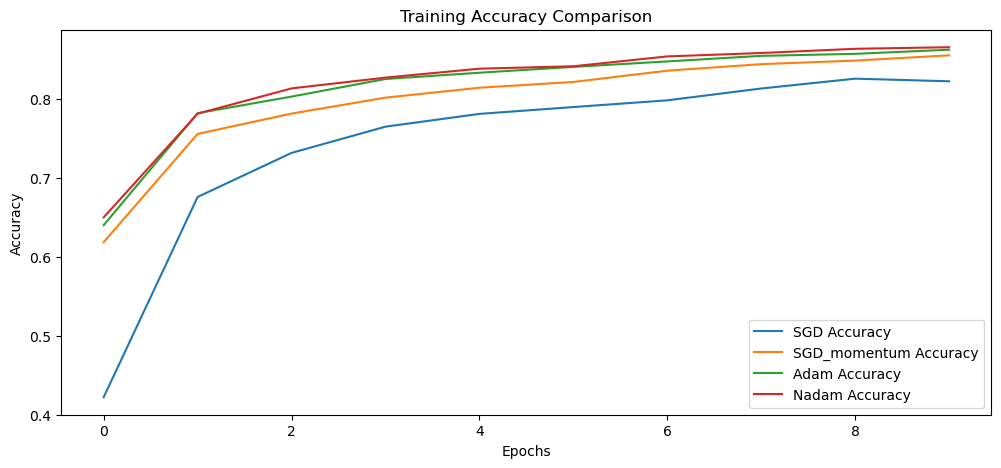

In [17]:
# Plot Training Accuracy
plt.figure(figsize=(12, 5))
for opt_name, hist in history_dict.items():
    plt.plot(hist['accuracy'], label=f'{opt_name} Accuracy')
plt.title('Training Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

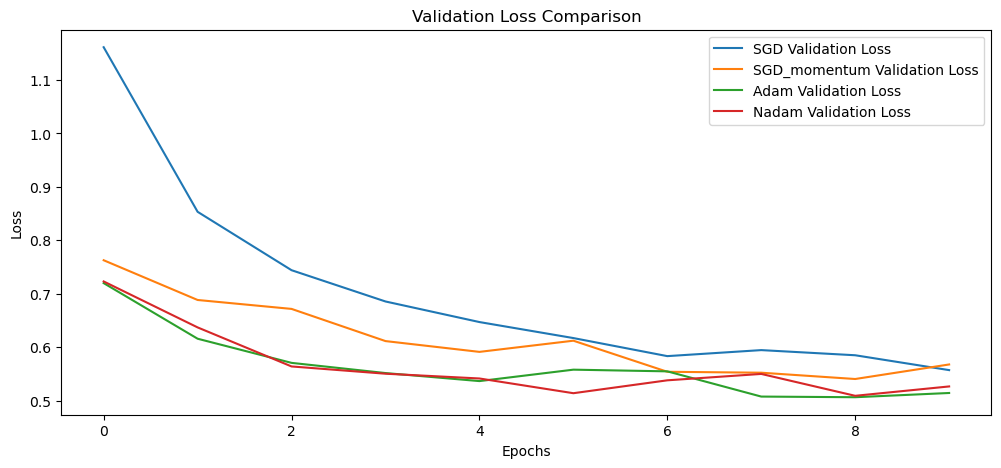

In [19]:
# Plot Validation Loss
plt.figure(figsize=(12, 5))
for opt_name, hist in history_dict.items():
    plt.plot(hist['val_loss'], label=f'{opt_name} Validation Loss')
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

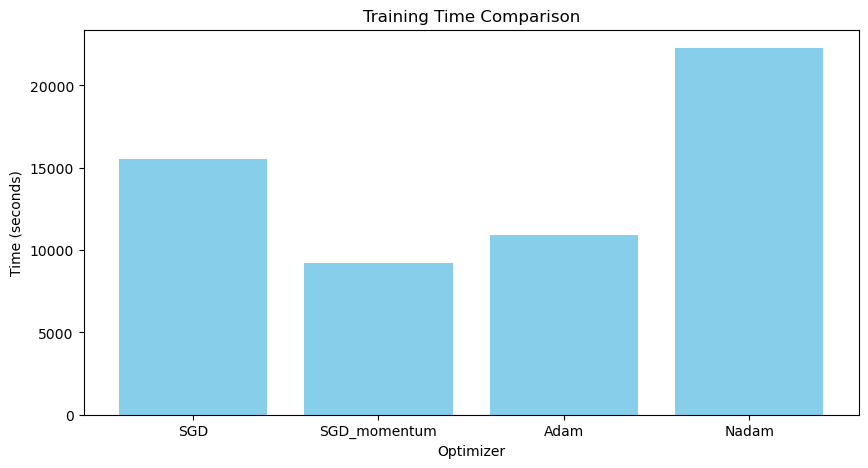

In [23]:
# Corrected plotting of total training time per optimizer
plt.figure(figsize=(10, 5))
optimizer_names = list(optimizers.keys())
training_times = [train_time_log[opt] for opt in optimizer_names]

plt.bar(optimizer_names, training_times, color='skyblue')
plt.title('Training Time Comparison')
plt.xlabel('Optimizer')
plt.ylabel('Time (seconds)')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


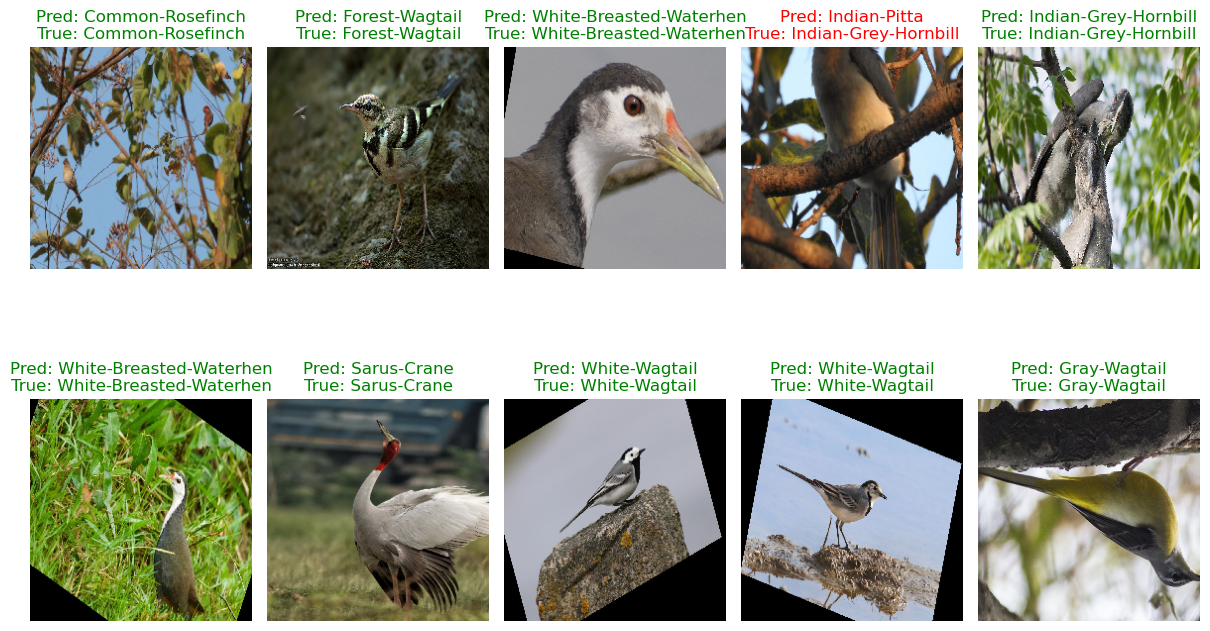

In [29]:
# Predictions Visualization (Best Model)
best_model = load_model("model_Nadam.h5")  # Change if another model is best
image_paths = []
true_labels = []

for class_name in os.listdir(valid_dir):
    class_path = os.path.join(valid_dir, class_name)
    if os.path.isdir(class_path):
        for img in os.listdir(class_path):
            image_paths.append(os.path.join(class_path, img))
            true_labels.append(class_name)

selected_indices = random.sample(range(len(image_paths)), 10)
selected_images = [image_paths[i] for i in selected_indices]
selected_labels = [true_labels[i] for i in selected_indices]


plt.figure(figsize=(12, 8))
for i, img_path in enumerate(selected_images):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred_probs = best_model.predict(img_array)
    pred_class = np.argmax(pred_probs)
    predicted_label = class_labels[pred_class]
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")
    color = "green" if predicted_label == selected_labels[i] else "red"
    plt.title(f"Pred: {predicted_label}\nTrue: {selected_labels[i]}", color=color)
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


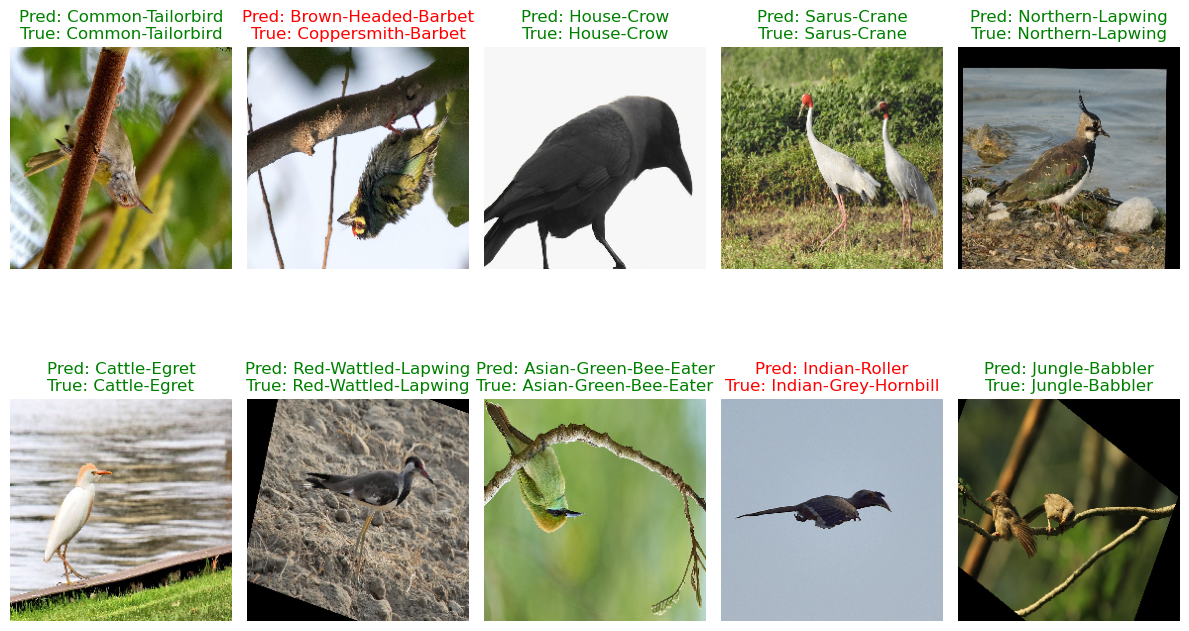

In [35]:
# Predictions Visualization 
best_model = load_model("model_Adam.h5")  # Change if another model is best
image_paths = []
true_labels = []

for class_name in os.listdir(valid_dir):
    class_path = os.path.join(valid_dir, class_name)
    if os.path.isdir(class_path):
        for img in os.listdir(class_path):
            image_paths.append(os.path.join(class_path, img))
            true_labels.append(class_name)

selected_indices = random.sample(range(len(image_paths)), 10)
selected_images = [image_paths[i] for i in selected_indices]
selected_labels = [true_labels[i] for i in selected_indices]


plt.figure(figsize=(12, 8))
for i, img_path in enumerate(selected_images):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred_probs = best_model.predict(img_array)
    pred_class = np.argmax(pred_probs)
    predicted_label = class_labels[pred_class]
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")
    color = "green" if predicted_label == selected_labels[i] else "red"
    plt.title(f"Pred: {predicted_label}\nTrue: {selected_labels[i]}", color=color)
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


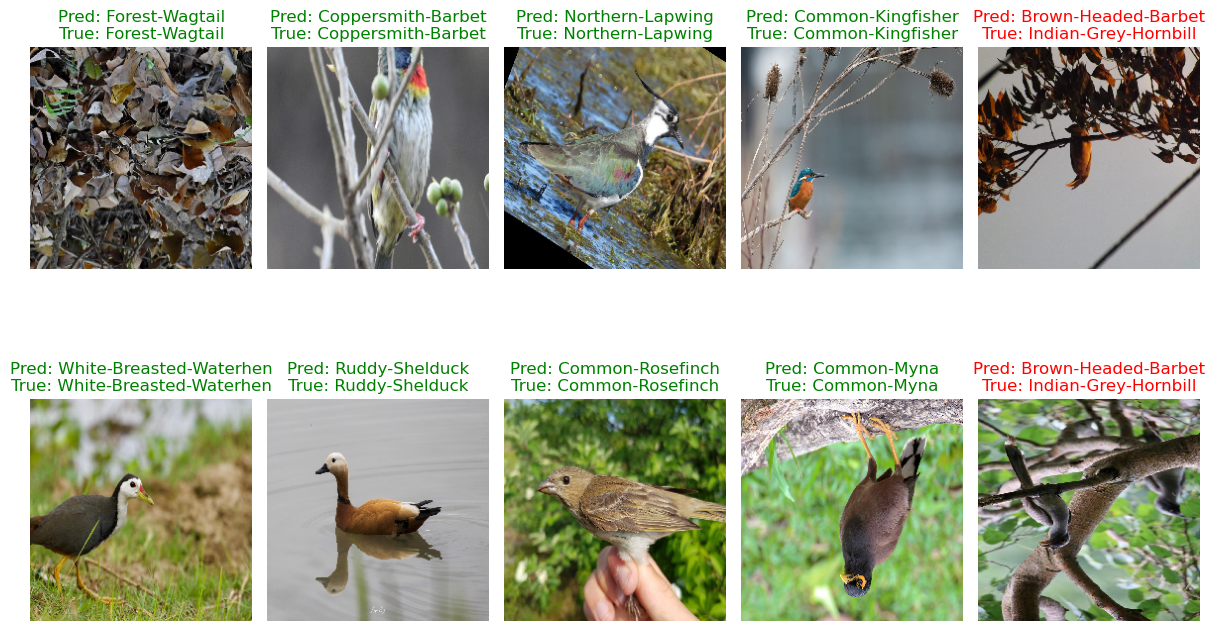

In [41]:
# Predictions Visualization 
best_model = load_model("model_SGD_momentum.h5")  # Change if another model is best
image_paths = []
true_labels = []

for class_name in os.listdir(valid_dir):
    class_path = os.path.join(valid_dir, class_name)
    if os.path.isdir(class_path):
        for img in os.listdir(class_path):
            image_paths.append(os.path.join(class_path, img))
            true_labels.append(class_name)

selected_indices = random.sample(range(len(image_paths)), 10)
selected_images = [image_paths[i] for i in selected_indices]
selected_labels = [true_labels[i] for i in selected_indices]


plt.figure(figsize=(12, 8))
for i, img_path in enumerate(selected_images):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred_probs = best_model.predict(img_array)
    pred_class = np.argmax(pred_probs)
    predicted_label = class_labels[pred_class]
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")
    color = "green" if predicted_label == selected_labels[i] else "red"
    plt.title(f"Pred: {predicted_label}\nTrue: {selected_labels[i]}", color=color)
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


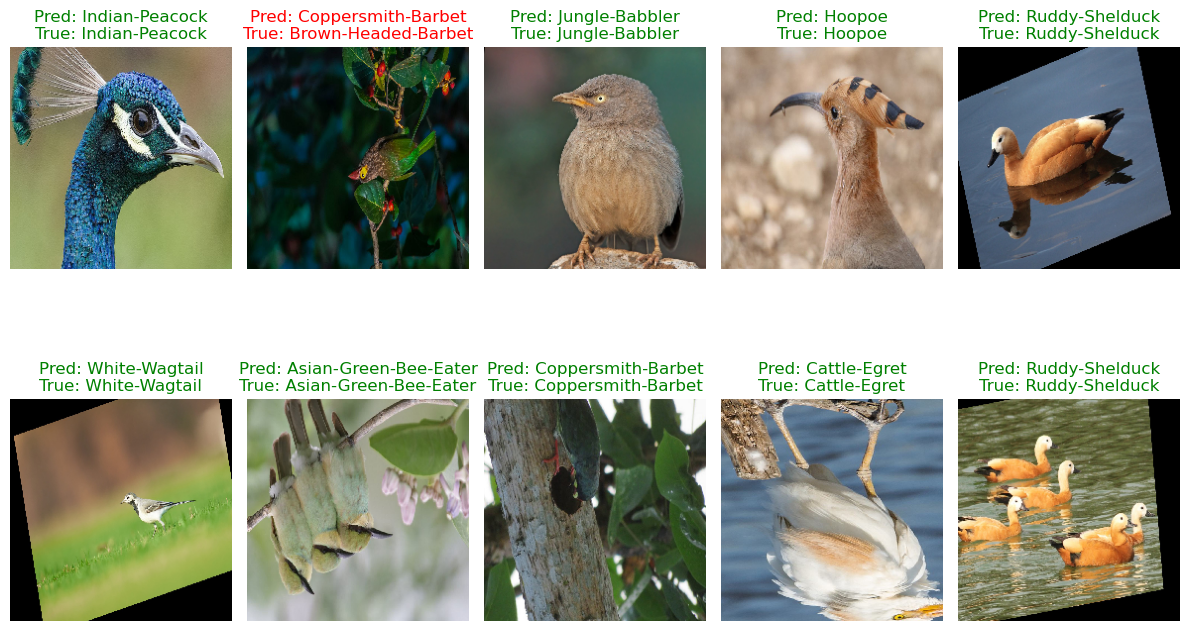

In [45]:
# Predictions Visualization 
best_model = load_model("model_SGD.h5")  # Change if another model is best
image_paths = []
true_labels = []

for class_name in os.listdir(valid_dir):
    class_path = os.path.join(valid_dir, class_name)
    if os.path.isdir(class_path):
        for img in os.listdir(class_path):
            image_paths.append(os.path.join(class_path, img))
            true_labels.append(class_name)

selected_indices = random.sample(range(len(image_paths)), 10)
selected_images = [image_paths[i] for i in selected_indices]
selected_labels = [true_labels[i] for i in selected_indices]


plt.figure(figsize=(12, 8))
for i, img_path in enumerate(selected_images):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred_probs = best_model.predict(img_array)
    pred_class = np.argmax(pred_probs)
    predicted_label = class_labels[pred_class]
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")
    color = "green" if predicted_label == selected_labels[i] else "red"
    plt.title(f"Pred: {predicted_label}\nTrue: {selected_labels[i]}", color=color)
plt.tight_layout()
plt.show()

In [47]:
# Summary Table
print("\nOptimizer Training Summary:")
print(f"{'Optimizer':<15}{'Val Accuracy (%)':<18}{'Val Loss':<12}{'Total Time (s)':<18}{'Time/Epoch (s)':<18}{'Converged Epoch':<17}")
for opt_name in optimizers.keys():
    val_acc = val_scores[opt_name]["val_accuracy"]
    val_loss = val_scores[opt_name]["val_loss"]
    total_time = train_time_log[opt_name]
    time_per_epoch = train_time_log[f"{opt_name}_time_per_epoch"]
    converge_epoch = train_time_log[f"{opt_name}_converge_epoch"]
    print(f"{opt_name:<15}{val_acc:<18.2f}{val_loss:<12.4f}{total_time:<18.2f}{time_per_epoch:<18.2f}{converge_epoch:<17}")


Optimizer Training Summary:
Optimizer      Val Accuracy (%)  Val Loss    Total Time (s)    Time/Epoch (s)    Converged Epoch  
SGD            83.37             0.5578      15525.66          1552.57           10               
SGD_momentum   83.45             0.5624      9210.53           921.05            9                
Adam           83.60             0.5367      10893.32          1089.33           9                
Nadam          84.84             0.4997      22267.72          2226.77           9                


In [51]:
# Function to evaluate the model on the test set (validation set)
def evaluate_model_on_test_set(model_path, valid_generator):
    model = load_model(model_path)
    
    # Evaluate the model
    y_true = valid_generator.classes
    y_pred_probs = model.predict(valid_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    # Calculate accuracy
    accuracy = np.sum(y_true == y_pred) / len(y_true) * 100
    
    return accuracy

# Evaluate models and print the testing accuracy for each optimizer's model
test_accuracies = {}
for opt_name in optimizers.keys():
    print(f"\nEvaluating model with {opt_name} optimizer on test set...")
    model_path = f"model_{opt_name}.h5"
    test_accuracy = evaluate_model_on_test_set(model_path, valid_generator)
    test_accuracies[opt_name] = test_accuracy

    # Print the testing accuracy for each optimizer
    print(f"Test Accuracy for {opt_name}: {test_accuracy:.2f}%")

# Optionally, save test accuracies to a file
with open("test_accuracies.pkl", "wb") as f:
    pickle.dump(test_accuracies, f)

# Display summary of test accuracies
print("\nTest Accuracy Summary:")
print(f"{'Optimizer':<15}{'Test Accuracy (%)':<20}")
for opt_name, accuracy in test_accuracies.items():
    print(f"{opt_name:<15}{accuracy:<20.2f}")



Evaluating model with SGD optimizer on test set...


235/235 ━━━━━━━━━━━━━━━━━━━━ 145s 612ms/step
Test Accuracy for SGD: 82.91%

Evaluating model with SGD_momentum optimizer on test set...


235/235 ━━━━━━━━━━━━━━━━━━━━ 142s 600ms/step
Test Accuracy for SGD_momentum: 82.91%

Evaluating model with Adam optimizer on test set...


235/235 ━━━━━━━━━━━━━━━━━━━━ 140s 591ms/step
Test Accuracy for Adam: 83.55%

Evaluating model with Nadam optimizer on test set...


235/235 ━━━━━━━━━━━━━━━━━━━━ 139s 587ms/step
Test Accuracy for Nadam: 84.37%

Test Accuracy Summary:
Optimizer      Test Accuracy (%)   
SGD            82.91               
SGD_momentum   82.91               
Adam           83.55               
Nadam          84.37               


In [73]:
import os
import random
from PIL import Image

# Directory path to your dataset (e.g., one of the class folders)
dataset_dir = "S:/Labs/dl/Birds_25/train"

# List all class directories
class_dirs = os.listdir(dataset_dir)

# Pick a random class folder
random_class = random.choice(class_dirs)
class_path = os.path.join(dataset_dir, random_class)

# List all images in the selected class folder
image_files = os.listdir(class_path)

# Pick a random image
random_image = random.choice(image_files)
image_path = os.path.join(class_path, random_image)

# Open the image
img = Image.open(image_path)

# Print the dimensions of the image
print(f"Image dimensions for {random_image}: {img.size}")


Image dimensions for Common-Tailorbird_1325.jpg: (1200, 800)
